As usual, we'll start with cleaning and attempt to EDA at the end.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/FMCG_2022_2024.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '') #Clean the titles for ease of coding
print(df.shape)
df.head()

(190757, 14)


,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


All right, we have a formal 190kish sales records to look at. I'm unsure if the default order is appropriate to have sku first, but I guess it's akin to having people when dealing with some health dataset then getting more general from there. 14 initial features total. Depending upon what we do with this data, we'd likely set price as the target feature.

In [3]:
if sum(df.isnull().sum())==0:
    print("Phew, no nulls. Nothing else to say about that. Always a good policy to check though.")
else:
    print("Oh boy, we got some nulls to deal with. Let's get into the 'damage'.")
    print(df.columns[df.isnull().any()])

Phew, no nulls. Nothing else to say about that. Always a good policy to check though.


Honstly a shame in this case as I was hoping to also demo null handling. Oh well.

## Initial EDA (Exploratory Data Analysis)

In [4]:
#Yeah, let's make a formula to clean up the code:

def variable_analyzer(df, col, categorical_norm=True):
    print(f"Now looking at feature {df.columns.get_loc(col)}, {col}.")
    nulls = df[col].isnull().sum()
    if nulls > 0:
        print(f"Reminder that {df.columns[i]} has {nulls} nulls - deal with them noob.")
    print('~~~')
    #The first branch deals with numeric; second categorical.
    if len(df[df.columns[i]].value_counts()) > 10 and df[df.columns[i]].dtype in ['int64', 'float64']: #Arb. threshold
        print(df[df.columns[i]].describe()) #note that display could be another option.
    else:
        print(f"{df.columns[i]} has {df[df.columns[i]].value_counts().count()} categories.")
        print(df[df.columns[i]].value_counts(normalize=categorical_norm))

In [5]:
i = -1 #Bit of code I enjoy to make EDA coding easier.

In [6]:
i += 1
variable_analyzer(df, df.columns[i], categorical_norm=False)

Now looking at feature 0, date.
~~~
date has 1076 categories.
date
2024-07-30    248
2024-06-16    247
2023-08-02    247
2023-08-31    246
2023-11-20    244
             ... 
2022-02-24     13
2022-01-24     13
2022-02-27     13
2022-01-22     12
2022-01-21      8
Name: count, Length: 1076, dtype: int64


Oh wow, they almost had a sale every single day in the three year period. So, they're obviously open every day of the week. Oh interesting, it seems that the first recorded data wasn't even until 2022-1-21. So, considering that February 2024 was a leap year then they had at last one sale every single day. Regardless, let's still figure out trends - weekday, month, year, and seasonal. Holidays might still affect sales too, but I doubt I'll get into that when this is just a demo.

In [7]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 1, sku.
~~~
sku has 30 categories.
sku
MI-006    0.043097
MI-026    0.043071
YO-029    0.041461
YO-005    0.041377
YO-012    0.040465
RE-004    0.040067
YO-014    0.039999
YO-001    0.039705
RE-007    0.039259
RE-015    0.038615
MI-023    0.037755
JU-021    0.036397
YO-009    0.035532
SN-027    0.033734
YO-003    0.033241
MI-022    0.032759
YO-016    0.031406
RE-025    0.031401
SN-010    0.030772
RE-017    0.030133
SN-013    0.028838
YO-020    0.028392
SN-019    0.027412
MI-002    0.026563
MI-011    0.025493
YO-024    0.025425
MI-008    0.025042
SN-028    0.024896
YO-018    0.024146
SN-030    0.023548
Name: proportion, dtype: float64


Retroactively, from the segment section:<br>
mi - milk<br>
yo - yogurt<br>
re - ready meal<br>
sn - snack bar<br>
ju - juice<br>



Somewhat evenly distributed where no one-product dominates. Ie even the smallest is not so much undersold than the top milk products. Also, we didn't even consider their price, rate of consumption, etc..

In [8]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 2, brand.
~~~
brand has 14 categories.
brand
SnBrand2    0.140362
YoBrand4    0.116992
YoBrand3    0.099504
MiBrand3    0.095556
YoBrand2    0.090948
ReBrand4    0.077874
YoBrand1    0.073706
MiBrand1    0.068590
ReBrand2    0.061534
MiBrand4    0.043071
ReBrand1    0.040067
JuBrand3    0.036397
SnBrand3    0.028838
MiBrand2    0.026563
Name: proportion, dtype: float64


I'm unsure if brands do multiple things - ie does milk brand 1 also sell yogurt (under brand 1)? Anyways, of interest later will be to formula add them together and compare stuff. Ie Sn, whatever that is, clearly win ovrall. Yet how much within their own sn department do they dominate?

In [9]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 3, segment.
~~~
segment has 13 categories.
segment
Yogurt-Seg1       0.140760
Yogurt-Seg3       0.130071
Milk-Seg2         0.126365
Yogurt-Seg2       0.110318
Milk-Seg3         0.080852
ReadyMeal-Seg1    0.077874
SnackBar-Seg1     0.075856
ReadyMeal-Seg2    0.070199
SnackBar-Seg2     0.059610
Juice-Seg3        0.036397
SnackBar-Seg3     0.033734
ReadyMeal-Seg3    0.031401
Milk-Seg1         0.026563
Name: proportion, dtype: float64


Hmm, what did this really change? Regardless, we at least see a formal clarification of each thing now.<br><br>
Yeah, I'm honestly unsure at the moment how these segments are working. Ie from a quick scan above (in the brand sectin) yogurts took up approximately 40% of sales. That is still true now, yet earlier it was with 4 brands and here with just 3 categories that don't appear to be sums of the more granular brand. So, brand, as an analogy Greek Yogurt, does not seem to be a complete sub-category of whatever segment is. Per a ChatGPT query it would seem to be which type of yogurt ie vanilla, chocolate, etc.. Hence, evrythingmaks sense.
<br> But maybe not - there only appears to be one type of juice.... and it's assigned to segment3. So, that seem to imply Seg3 across the 5 items (yogurt, milk, readymeal, snackbar, and juice) are similar in flavor/type. So too regarding Seg1 and 2, seemingly.
<br><br>
Let this be a great example of the utility of domain knowledge. However, I'd say I'm doing pretty welll looking at this type of data professionally for the first time ever.

In [10]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 4, category.
~~~
category has 5 categories.
category
Yogurt       0.381150
Milk         0.233779
ReadyMeal    0.179474
SnackBar     0.169200
Juice        0.036397
Name: proportion, dtype: float64


Unsurprising to me that yogurt is the most purchased item per buying habbits and then milk per that and preservability. A bit surpised that snack bars aren't higher and likely now I can accurately transition into an interesting observation about this dataset - we're in Pland. Oh, I think I already mentioned that. Regardless, it's true - likely their eating (as well as perhaps the raw status of yogurt for example - maybe it's just a lot better over there, let alone cultural differences that may exist and the like).

In [11]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 5, channel.
~~~
channel has 3 categories.
channel
Retail        0.333870
E-commerce    0.333508
Discount      0.332622
Name: proportion, dtype: float64


About as even as you can get. Potentially might drop for simplicity, but perhaps across all facets it's not even. Ie maybe all snacks are retail, reflecting the spurious nature of snacking's definition.

In [12]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 6, region.
~~~
region has 3 categories.
region
PL-North      0.333644
PL-South      0.333235
PL-Central    0.333120
Name: proportion, dtype: float64


I'm also surprised that this is even. Albeit synthetic, but shocking. Yet, once again, specific products or prices might be skewed.

In [13]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 7, pack_type.
~~~
pack_type has 3 categories.
pack_type
Carton       0.333781
Multipack    0.333146
Single       0.333073
Name: proportion, dtype: float64


See above. Particularly when it would come to product ie milk I'd expect to see less multi-pack. Also curious if price would be correspondingly adjusted. I guess either-way, whether price is gross or per-unit the point would be the same to except proportionally higher rates for singles. Cartons likely slightly lwoer and the cheapest being multi-pack.

In [14]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 8, price_unit.
~~~
count    190757.000000
mean          5.251979
std           2.166705
min           1.500000
25%           3.380000
50%           5.250000
75%           7.130000
max           9.000000
Name: price_unit, dtype: float64


Oh, yeah I guess they did go into 'unit' specificity. Honestly, I don't think I like that as $24/24 /= $1/1 as it still requires that spending of $24 for that one type of item. What are people's budgets? What is the life now for all of them to be used by this one customer?

Later we'll look into average yogurt... and the various devisions. I think for my sake we'll move this to the end for aesthetics.

In [15]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 9, promotion_flag.
~~~
promotion_flag has 2 categories.
promotion_flag
0    0.8508
1    0.1492
Name: proportion, dtype: float64


Seemingly if there was an add for the item - and phew it's not even.

Likely the item is new (unsure if we can confirm that from the data), not as popular (motivate sales), popular (potentially - ride the gravy train), and/or expensive. I mean, ultimately they hope to make money, so presumably whatever the sku's comparative features are...

In [16]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 10, delivery_days.
~~~
delivery_days has 5 categories.
delivery_days
4    0.202278
5    0.200286
1    0.199883
3    0.199327
2    0.198226
Name: proportion, dtype: float64


To the store or to the consumer? Seemingly to the store as recall 1/3 of the sales were retail. I'm unaware of the trucking and preserving process in general (let alone Poland) yet would ventue to still assume milk then yogurt would likely be the most affected by this. Unsure if juice or snack bars are even refridgerated at all. I'd also aassume, which I may be wrong, that the meals are frozen and likely have accomodating features to maintain that; eh, they're called 'ready meals' so likely at most refridgerated.

In [17]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 11, stock_available.
~~~
count    190757.000000
mean        157.697652
std          52.736104
min         -12.000000
25%         124.000000
50%         155.000000
75%         192.000000
max         405.000000
Name: stock_available, dtype: float64


Was this at the store? Ie 405 yogurts (example) on any one given transaction opportunity? Yeah, really unsure about this one. I do not see ay other infomation about this on Kaggle.

Hmm, and we have -12 for the minimum. Will likely need to change that. Presumably it was 12; well, maybe not. Perhaps they were supposed to bring 12 more than they had. So too below for delivred quantity.

In [18]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 12, delivered_qty.
~~~
count    190757.000000
mean        179.333655
std          40.037475
min         -11.000000
25%         152.000000
50%         179.000000
75%         206.000000
max         366.000000
Name: delivered_qty, dtype: float64


Hmm, seemingly related as they have similar yet smaller numbers. Of interest is that the mean (and median) is much highr for delivered though, implying that (given there's an order) it's a pretty sizable amount of the stock.

In [19]:
i += 1
variable_analyzer(df, df.columns[i])

Now looking at feature 13, units_sold.
~~~
count    190757.000000
mean         19.919709
std          11.770077
min         -25.000000
25%          12.000000
50%          18.000000
75%          25.000000
max         139.000000
Name: units_sold, dtype: float64


Hmm, I'm guessing this is for the entire day. Also, bear in mind the multi-pack discussion.... We might change our minds once we see the prices though.
<br><br>
I'm guessing any negatives are a sign of returns.

## Feature Engineering

Well, at least the first round of it.

In [20]:
df['date'].describe

<bound method NDFrame.describe of 0         2022-01-21
1         2022-01-21
2         2022-01-21
3         2022-01-21
4         2022-01-21
             ...    
190752    2024-12-31
190753    2024-12-31
190754    2024-12-31
190755    2024-12-31
190756    2024-12-31
Name: date, Length: 190757, dtype: object>

In [21]:
#Keep data whole, but break into weekday, month, and of couse year.

#Not going to bother to analyze Polish holidays when this is a demo, but will at least take note of them.
#and obviously re-analyze/analyze when tehy'e actualy made

df['date'] = pd.to_datetime(df['date'])

df['weekday']   = df['date'].dt.day_name()
df['monthday']  = df['date'].dt.day
df['month']     = df['date'].dt.month_name() 
df['year']      = df['date'].dt.year

Now let's formally look at the date components:

In [22]:
df['weekday'].value_counts(normalize=True)

weekday
Monday       0.143764
Sunday       0.143224
Tuesday      0.143224
Saturday     0.142632
Thursday     0.142553
Wednesday    0.142485
Friday       0.142118
Name: proportion, dtype: float64

Unsurprising given the observations earlir the near even split.

In [23]:
print(df['monthday'].value_counts(normalize=True, ascending=False)[:3])

df['monthday'].value_counts(normalize=True, ascending=True)[:3]

monthday
28    0.033315
24    0.033304
27    0.033299
Name: proportion, dtype: float64


monthday
31    0.019323
30    0.031108
5     0.032041
Name: proportion, dtype: float64

Recall that we don't always have day 31 in the Gregorian calendar. Otherwise, essentially evenly distributed.

In [24]:
df['month'].value_counts(normalize=True)

month
December     0.099021
October      0.094445
November     0.093192
August       0.090728
July         0.089795
September    0.088877
May          0.085077
June         0.084878
April        0.076044
March        0.070996
January      0.064585
February     0.062362
Name: proportion, dtype: float64

Hmmm,  we are dfinitly seeing some trends here. Hence the time series function. What's shocking is that it'snot even seasonal but seeemingly calendar as the earlier months floundr (all 3, in fact) and the later months spike up. Perhaps holidays justify that trend. Regardless, it's shocking. Furthermore, the trend continues as the next fewest months of sales are the next three months in the calendar!
<br>
It's definitly incumbent upon us to explore months with any other features. Of note also is that it's not perfectly calendar. Ie dec oct nov vs. dec nov oct, etc..

In [25]:
df['year'].value_counts(normalize=True)

year
2024    0.440141
2023    0.406533
2022    0.153326
Name: proportion, dtype: float64

Hmm, what happened in 2022? Definitely warrants attention

### Getting the various features data-ready

Actually, I might skip this if I don't decide to actually model as it'll make it easier for data visualziation purposes, which is what I'm going for right now, to leave them as is.

On the to-do list would be:

Categorical to dummify: category, channel, region, pack_type, weekday, month

Hmm, when it comes to sku, brands, segments...yeah, we'd also need to dummify them as ultimately leaving them as numbers would also skew any models as there's no inherent link between one sku being called 1 vs. another 2.

In [26]:
#Per my aesthetics:

df_cleaned =  df.drop(['price_unit'], axis = 1)
df_cleaned['price_unit'] = df['price_unit']
df_cleaned.head()

,date,sku,brand,segment,category,channel,region,pack_type,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold,weekday,monthday,month,year,price_unit
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,0,1,141,128,9,Friday,21,January,2022,2.38
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1,3,0,129,0,Friday,21,January,2022,1.55
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,0,5,118,161,8,Friday,21,January,2022,4.00
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,0,2,81,114,7,Friday,21,January,2022,5.16
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,0,4,148,204,12,Friday,21,January,2022,7.66


In [27]:
#Since we'll be working with this for the next chunk, I may as well simplify matters.
df.to_csv('../data/data_cleaned_i.csv', index=False)

In [28]:
df = pd.read_csv('../data/data_cleaned_i.csv')
df.shape

(190757, 18)

## Next Step EDA: Interactions with our Target

In [29]:
#Hmm, likely I should make a formula to speed up this code. If if in the category branch than this default; otherwise
#(in numeric) do this.

In [30]:
target = 'price_unit'
exceptions_tonot_analze = ['date', target]

Mmk, let's start with bivariate analysis. To make things a bit easier, I'll bisect the featues into numerical and categorical. So we should expect 16 featueres in total (18 at the moment total columns less our target, price, and date (not bothing with all these dates...I don't think there's anything in there off hand)).<br>
Likely should code a formal check, but eh.

In [31]:
features_categorical = [i for i in df.columns if df.dtypes[i] == 'O']
for i in exceptions_tonot_analze:
    if i in features_categorical:
        features_categorical.remove(i) #Yeah, we're not bothering by default to look at date.
features_categorical.append('monthday') #As this is moreso categorical
features_categorical.append('promotion_flag') #As this is also some type of categorical. See below.
print(features_categorical)
print(len(features_categorical))

['sku', 'brand', 'segment', 'category', 'channel', 'region', 'pack_type', 'weekday', 'month', 'monthday', 'promotion_flag']
11


In [32]:
features_numerical = [i for i in df.columns if df.dtypes[i] != 'O']
for i in exceptions_tonot_analze:
    if i in features_numerical:
        features_numerical.remove(i)
features_numerical.remove('monthday')
features_numerical.remove('promotion_flag')
print(features_numerical)
print(len(features_numerical))

['delivery_days', 'stock_available', 'delivered_qty', 'units_sold', 'year']
5


In [33]:
if len(features_categorical) + len(features_numerical) + len(exceptions_tonot_analze) != df.shape[1]:
    print(f"Make sure we have all of our columns accounted for as they don't add up.")
else:
    print(f"We have all of our columns accounted for in our categorical/numerical features, don't worry.")

We have all of our columns accounted for in our categorical/numerical features, don't worry.


In [34]:
#Yeah, let's make some code to make it a bit easier on the eyes.

#This will assume that the features to be looked at are already seperated out (into 
#'features_categorical' and 'featurs_numeric')
#Also assumes numpy and seaborne has been imported.

#Re. future usages of this: I think I want to change this as when I later added a formal quarter column it made an issue.
#I could just re.run the code... but eh.

#For now at least I won't auto-code a boxplot of some kind.
def bivariate_analysis(feature, target):
    if feature in features_categorical:
        print(f"Comparing {features_categorical[j]} with our target feature of {target}.")
        print(f"Recall that {features_categorical[j]} has {len(df[features_categorical[j]].value_counts())} categories.")
        display(df.groupby(features_categorical[j])[target].describe())
    elif feature in features_numerical:
        print(f"Comparing {features_numerical[j]} with our target feature of {target}.")
        print(f"Their correlation is approximately {round(df[[features_numerical[j], target]].corr()[features_numerical[j]][1], 3)}.")
        sns.scatterplot(x=features_numerical[j], y=target, data=df)
        plt.show()

In [35]:
j = -1

In [36]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing sku with our target feature of price_unit.
Recall that sku has 30 categories.


,count,mean,std,min,25%,50%,75%,max
sku,,,,,,,,
JU-021,6943.0,5.265496,2.182778,1.5,3.3450,5.300,7.165,9.00
MI-002,5067.0,5.235919,2.184712,1.5,3.3200,5.230,7.125,9.00
MI-006,8221.0,5.240337,2.166728,1.5,3.3700,5.240,7.090,9.00
MI-008,4777.0,5.209793,2.153069,1.5,3.3800,5.150,7.080,9.00
MI-011,4863.0,5.223298,2.146214,1.5,3.3600,5.210,7.050,9.00
MI-022,6249.0,5.240912,2.184456,1.5,3.3600,5.250,7.120,9.00
MI-023,7202.0,5.203219,2.184634,1.5,3.2900,5.190,7.110,9.00
MI-026,8216.0,5.224004,2.163871,1.5,3.3500,5.210,7.110,9.00
RE-004,7643.0,5.270156,2.154299,1.5,3.4200,5.250,7.130,9.00


In [37]:
# sns.boxplot(x=features_categorical[j], y=target, data=df)
# plt.show()

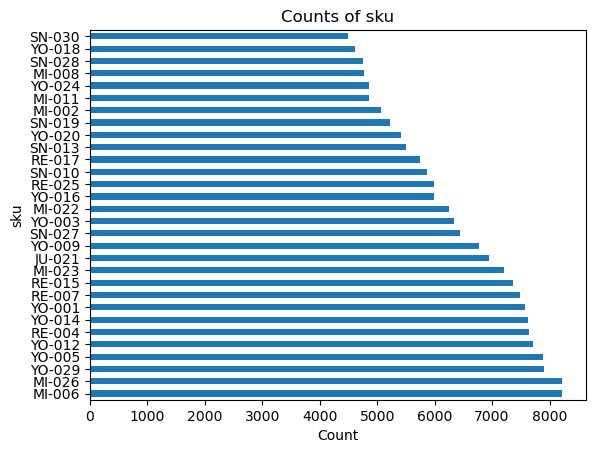

In [38]:
df[features_categorical[j]].value_counts().plot(kind='barh')
plt.title(f'Counts of {features_categorical[j]}')
plt.xlabel('Count')
plt.ylabel(features_categorical[j])
plt.show()

Unfortunately not so much to comment on as all Skus, regardless of brand or whatever ar basically the same across the spectrum of statistics: mean, std, quartiles, and the extremes. There counts, however, do change.

In [39]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing brand with our target feature of price_unit.
Recall that brand has 14 categories.


,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
JuBrand3,6943.0,5.265496,2.182778,1.5,3.345,5.30,7.165,9.00
MiBrand1,13084.0,5.234004,2.159060,1.5,3.360,5.23,7.080,9.00
MiBrand2,5067.0,5.235919,2.184712,1.5,3.320,5.23,7.125,9.00
MiBrand3,18228.0,5.217864,2.176291,1.5,3.330,5.20,7.100,9.00
MiBrand4,8216.0,5.224004,2.163871,1.5,3.350,5.21,7.110,9.00
ReBrand1,7643.0,5.270156,2.154299,1.5,3.420,5.25,7.130,9.00
ReBrand2,11738.0,5.279955,2.160881,1.5,3.400,5.30,7.150,9.00
ReBrand4,14855.0,5.267214,2.174973,1.5,3.370,5.29,7.160,9.00
SnBrand2,26775.0,5.246808,2.157675,1.5,3.390,5.25,7.110,9.00


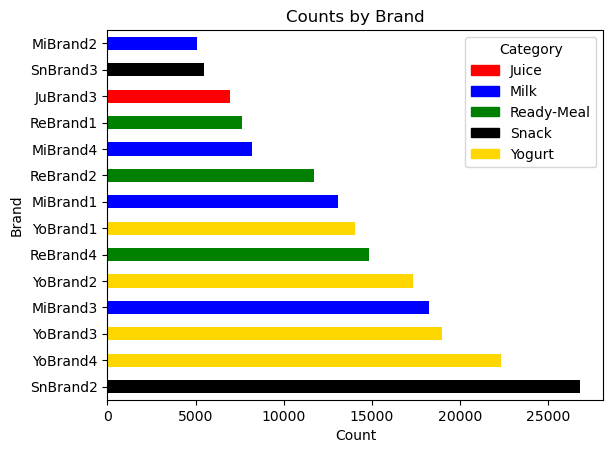

In [40]:
#I'm planning on using this one for the demo. Hence, slightly different code.

counts = df[features_categorical[j]].value_counts()
brands = counts.index.tolist()

def assign_group(brand):
    brand = brand.lower()
    if 'yo' in brand:
        return 'gold'   
    elif 'ju' in brand:
        return 'red'    
    elif 're' in brand:
        return 'green'   
    elif 'sn' in brand:
        return 'black'
    else: #Ie just milk
        return 'blue'
colors = [assign_group(brand) for brand in brands]

df[features_categorical[j]].value_counts().plot(kind='barh', color=colors)
plt.title(f'Counts by Brand')
plt.xlabel('Count')
plt.ylabel('Brand')

legend_patches = [
    mpatches.Patch(color='red', label='Juice'),
    mpatches.Patch(color='blue', label='Milk'),
    mpatches.Patch(color='green', label='Ready-Meal'),
    mpatches.Patch(color='black', label='Snack'),
    mpatches.Patch(color='gold', label='Yogurt')
]
plt.legend(handles=legend_patches, title='Category')

plt.show()

Now we start to see a little deviation, yet everything is still mostly the same among the descriptive statistics. Count, however, does vary quite a bit. As we mentioned earlier, there's only one juice company (good for them). And,it seems that our hypothesis may be correct that the brands run across products.As, while we have 4 yogurts, listed 1-4, we don't have ready-meal3, snacks1, nor juice1-2!
<br><br> Potentially should choose differet colors, but eh - even for a demo this is enough.

In [41]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing segment with our target feature of price_unit.
Recall that segment has 13 categories.


,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Juice-Seg3,6943.0,5.265496,2.182778,1.5,3.345,5.30,7.1650,9.0
Milk-Seg1,5067.0,5.235919,2.184712,1.5,3.320,5.23,7.1250,9.0
Milk-Seg2,24105.0,5.225429,2.163441,1.5,3.360,5.21,7.0900,9.0
Milk-Seg3,15423.0,5.223004,2.175116,1.5,3.330,5.22,7.1000,9.0
ReadyMeal-Seg1,14855.0,5.267214,2.174973,1.5,3.370,5.29,7.1600,9.0
ReadyMeal-Seg2,13391.0,5.275551,2.156859,1.5,3.410,5.26,7.1400,9.0
ReadyMeal-Seg3,5990.0,5.277297,2.161495,1.5,3.400,5.32,7.1600,9.0
SnackBar-Seg1,14470.0,5.242651,2.160059,1.5,3.370,5.24,7.1175,9.0
SnackBar-Seg2,11371.0,5.255226,2.142862,1.5,3.430,5.25,7.1000,9.0


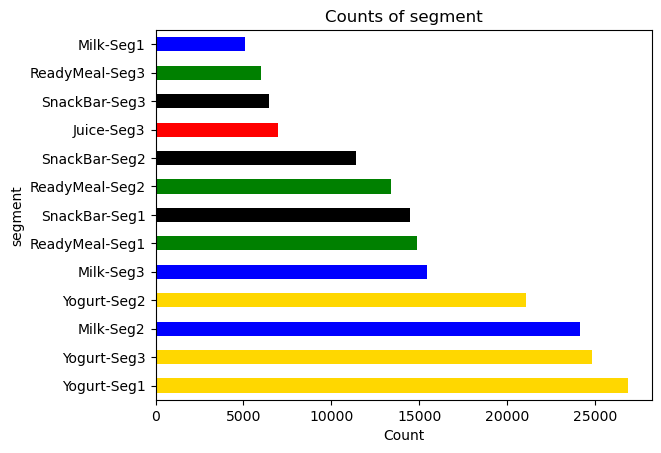

In [42]:
counts = df[features_categorical[j]].value_counts()
brands = counts.index.tolist()
# values = counts.values.tolist()

colors = [assign_group(brand) for brand in brands]

df[features_categorical[j]].value_counts().plot(kind='barh', color=colors)
plt.title(f'Counts of {features_categorical[j]}')
plt.xlabel('Count')
plt.ylabel(features_categorical[j])
plt.show()

Essentialy the same type of comments as before with brand. Two yogurts (I guess vanilla and vanilla, as an example of two differnt brands with the same 'segment') and milks combined; one snack separatd. Additionlly, the relative snack brands, thanks to that 'split', now have yogurts clearly dominating in sales. But, let us continue as it'd a bit hard for me to want to elaborate on something to abstract (when I can't appreciate brands of flavors). <br><br> It's not apprporiate to sad 'sadly', yet still, the trend continues of similar descriptive statistics save counnt.

In [43]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing category with our target feature of price_unit.
Recall that category has 5 categories.


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Juice,6943.0,5.265496,2.182778,1.5,3.345,5.300,7.1650,9.0
Milk,44595.0,5.225782,2.169863,1.5,3.340,5.210,7.1000,9.0
ReadyMeal,34236.0,5.272239,2.165488,1.5,3.400,5.285,7.1500,9.0
SnackBar,32276.0,5.245678,2.157072,1.5,3.390,5.250,7.1025,9.0
Yogurt,72707.0,5.260013,2.167961,1.5,3.380,5.260,7.1400,9.0


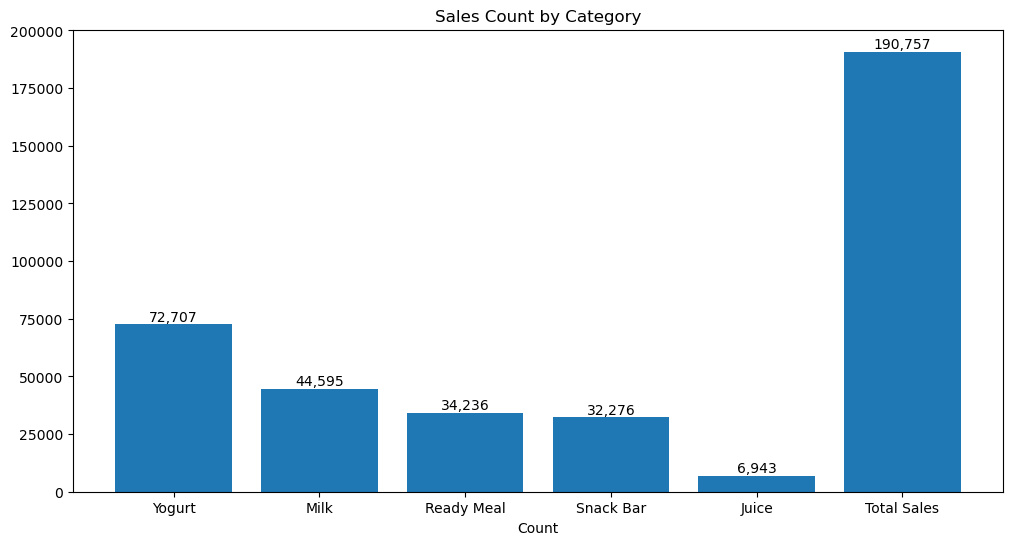

In [44]:
counts = df[features_categorical[j]].value_counts()
brands = counts.index.tolist()
brands = [brand if brand != 'ReadyMeal' else 'Ready Meal' for brand in brands]
brands = [brand if brand != 'SnackBar' else 'Snack Bar' for brand in brands]
brands.append('Total Sales') #Let's add total to compare
values = counts.values.tolist()
values.append(sum(values))

plt.figure(figsize=(12, 6))
bars = plt.bar(brands, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.title(f'Sales Count by Category')
plt.xlabel('Count');

In [45]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing channel with our target feature of price_unit.
Recall that channel has 3 categories.


,count,mean,std,min,25%,50%,75%,max
channel,,,,,,,,
Discount,63450.0,5.257220,2.169934,1.5,3.3800,5.25,7.14,9.0
E-commerce,63619.0,5.241760,2.165591,1.5,3.3700,5.24,7.12,9.0
Retail,63688.0,5.256965,2.164596,1.5,3.3875,5.26,7.13,9.0


Eh, all approximately the same - even with count. Nothing else to say. Again, we might notice a subtrend within a specific item, but at least with price - the same. <br><br>
Perhaps not relevant until later, but recall that 'flag' exists. The indication of a flag (whatver that is), 1, only has 29k entries so it's at least not explicitly the same as 'discount'. Which, I'm assuming is retail with some type of sale.

In [46]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing region with our target feature of price_unit.
Recall that region has 3 categories.


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
PL-Central,63545.0,5.248738,2.162481,1.5,3.38,5.26,7.11,9.0
PL-North,63645.0,5.249313,2.169904,1.5,3.37,5.24,7.14,9.0
PL-South,63567.0,5.257887,2.167740,1.5,3.37,5.26,7.13,9.0


Thankfully regional differences don't seem to account for any significant changes either. I'm unsure if all parts of Poland they're equally likely to get ingredients to produce whatever item (likely just one plant per item), but regardless prices are essenially the same anywhere in Poland.

In [47]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing pack_type with our target feature of price_unit.
Recall that pack_type has 3 categories.


,count,mean,std,min,25%,50%,75%,max
pack_type,,,,,,,,
Carton,63671.0,5.240501,2.164311,1.5,3.37,5.25,7.10,9.0
Multipack,63550.0,5.257041,2.167313,1.5,3.38,5.25,7.14,9.0
Single,63536.0,5.258418,2.168483,1.5,3.38,5.25,7.14,9.0


Hmm, now this is slightly more of a shock that it's also the same (recall this is synthetic data). However, I'm ultimatly unfamiliar with eating as well as so many other factors of Polish life to properly comment if this is reasonable to see or not.

In [48]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing weekday with our target feature of price_unit.
Recall that weekday has 7 categories.


,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Friday,27110.0,5.257154,2.157422,1.5,3.40,5.25,7.14,9.0
Monday,27424.0,5.246859,2.163127,1.5,3.37,5.24,7.13,9.0
Saturday,27208.0,5.241641,2.179192,1.5,3.35,5.23,7.14,9.0
Sunday,27321.0,5.260112,2.162045,1.5,3.39,5.26,7.12,9.0
Thursday,27193.0,5.259834,2.160694,1.5,3.40,5.25,7.12,9.0
Tuesday,27321.0,5.247194,2.183122,1.5,3.34,5.26,7.14,9.0
Wednesday,27180.0,5.251106,2.161299,1.5,3.37,5.26,7.11,9.0


See above, as my comments here are essentially the same. Just now reflecting weekday.

In [49]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing month with our target feature of price_unit.
Recall that month has 12 categories.


,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
April,14506.0,5.262986,2.164601,1.5,3.39,5.25,7.13,9.0
August,17307.0,5.226719,2.162721,1.5,3.34,5.23,7.08,9.0
December,18889.0,5.265545,2.175551,1.5,3.38,5.27,7.16,9.0
February,11896.0,5.250939,2.172615,1.5,3.38,5.27,7.15,9.0
January,12320.0,5.259806,2.173831,1.5,3.40,5.22,7.16,9.0
July,17129.0,5.242185,2.157202,1.5,3.36,5.24,7.11,9.0
June,16191.0,5.244509,2.176607,1.5,3.35,5.24,7.13,9.0
March,13543.0,5.249278,2.160970,1.5,3.38,5.26,7.08,9.0
May,16229.0,5.242068,2.169349,1.5,3.37,5.22,7.13,9.0


Phew, finally something to comment on. Anyways, like with the most of the features we have seen thus far, the only real change amount parts of a given feature are its count. So, we see again the trend we noticd earlier - where each quarter, as it progresses throughout the calendar year, gets larger and larger. And, yet again, the rest of the stats remain essentially the same.<br><br>Yeah, this finding is huge. Let's go ahead and make a nice chart out of it to use for the demonstrationn as this a great finding (to let the grocery store owners know).

In [50]:
month_to_quarter = {
    'January': 'Q1', 'February': 'Q1', 'March': 'Q1',
    'April': 'Q2', 'May': 'Q2', 'June': 'Q2',
    'July': 'Q3', 'August': 'Q3', 'September': 'Q3',
    'October': 'Q4', 'November': 'Q4', 'December': 'Q4'
}

df['quarter'] = df['month'].map(month_to_quarter)

In [51]:
#I'll first do a formal discussion on it though, although it's jsut grouped by the months we just saw:
df['quarter'].value_counts(normalize=True)

quarter
Q4    0.286658
Q3    0.269400
Q2    0.245999
Q1    0.197943
Name: proportion, dtype: float64

In [52]:
display(df.groupby('quarter')[target].describe())

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
Q1,37759.0,5.253236,2.168790,1.5,3.39,5.25,7.13,9.0
Q2,46926.0,5.249377,2.170364,1.5,3.37,5.24,7.13,9.0
Q3,51390.0,5.246408,2.158641,1.5,3.37,5.25,7.11,9.0
Q4,54682.0,5.258579,2.169726,1.5,3.37,5.27,7.14,9.0


Confirming what we assumed earlier re. counts. And, once again, the price distributions remain the same.

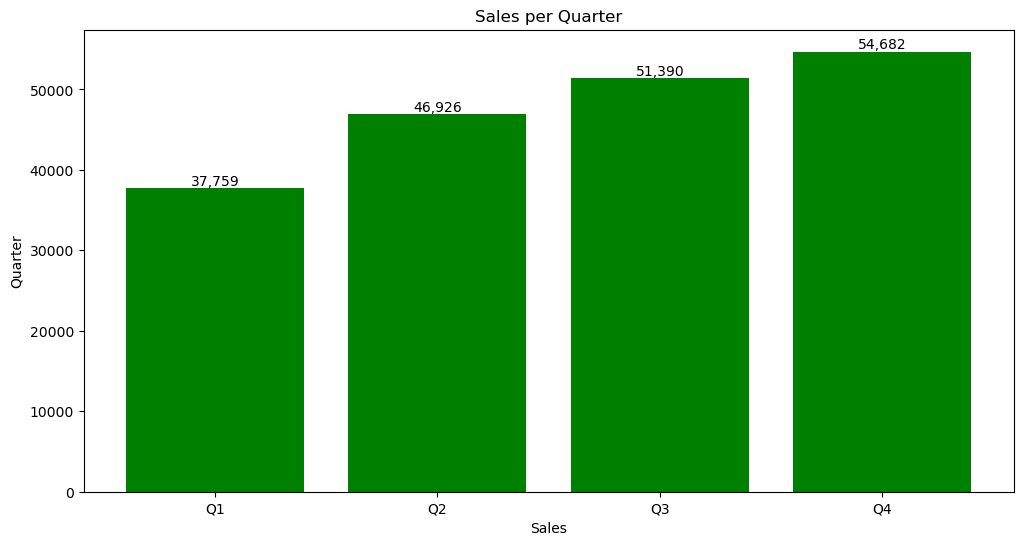

In [53]:
counts = df['quarter'].value_counts().sort_index()
quarters = counts.index.tolist()
values = counts.values.tolist()

plt.figure(figsize=(12, 6))
bars = plt.bar(quarters, values, color='green')
plt.xlabel('Sales')
plt.ylabel('Quarter')
plt.title('Sales per Quarter')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:,}', ha='center', va='bottom', fontsize=10,)

In [54]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing monthday with our target feature of price_unit.
Recall that monthday has 31 categories.


,count,mean,std,min,25%,50%,75%,max
monthday,,,,,,,,
1,6146.0,5.228158,2.154438,1.50,3.3625,5.215,7.08,9.0
2,6123.0,5.197225,2.161143,1.50,3.3100,5.180,7.04,9.0
3,6149.0,5.250818,2.164541,1.50,3.3900,5.290,7.11,9.0
4,6161.0,5.271375,2.174560,1.50,3.3900,5.290,7.15,9.0
5,6112.0,5.239115,2.156837,1.50,3.3700,5.220,7.09,9.0
6,6188.0,5.259798,2.151912,1.50,3.4100,5.250,7.12,9.0
7,6194.0,5.239307,2.171423,1.50,3.3100,5.215,7.10,9.0
8,6131.0,5.241404,2.176018,1.50,3.3400,5.250,7.13,9.0
9,6174.0,5.242647,2.180566,1.50,3.3300,5.240,7.16,9.0


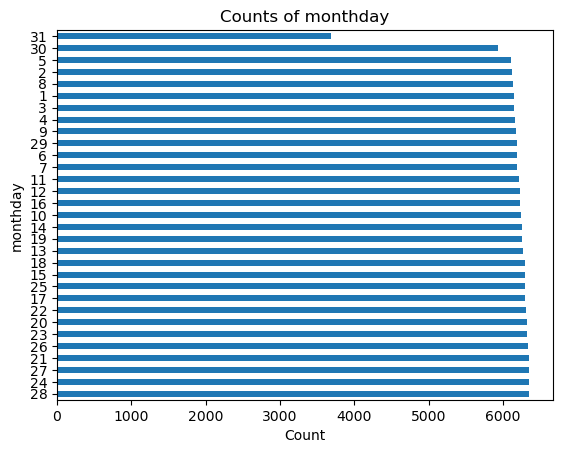

In [55]:
df[features_categorical[j]].value_counts().plot(kind='barh')
plt.title(f'Counts of {features_categorical[j]}')
plt.xlabel('Count')
plt.ylabel(features_categorical[j])
plt.show()

A bit more variety here with count, not even including the 31st (that isn't around every month).

In [56]:
j += 1
bivariate_analysis(features_categorical[j], target)

Comparing promotion_flag with our target feature of price_unit.
Recall that promotion_flag has 2 categories.


,count,mean,std,min,25%,50%,75%,max
promotion_flag,,,,,,,,
0,162296.0,5.248836,2.165855,1.5,3.38,5.25,7.12,9.0
1,28461.0,5.269902,2.171497,1.5,3.37,5.28,7.16,9.0


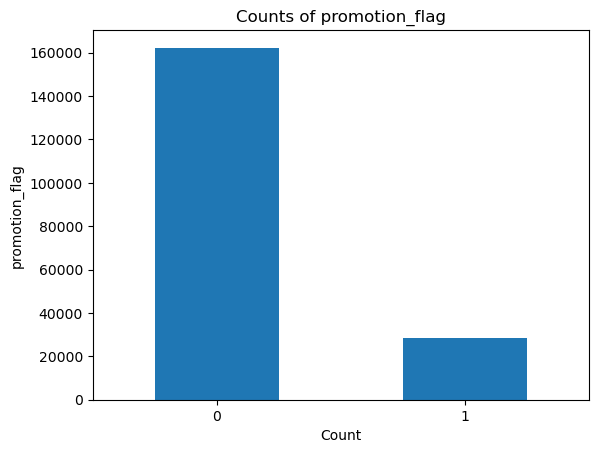

In [57]:
df[features_categorical[j]].value_counts().plot(kind='bar')
plt.title(f'Counts of {features_categorical[j]}')
plt.xlabel('Count')
plt.xticks(rotation=0)
plt.ylabel(features_categorical[j])
plt.show()

Recall that promotion flag is essentially categorical, arguably should change it but eh, 

#### Should be done with categoricals; onto numericals:

In [58]:
j = -1

Comparing delivery_days with our target feature of price_unit.
Their correlation is approximately 0.002.


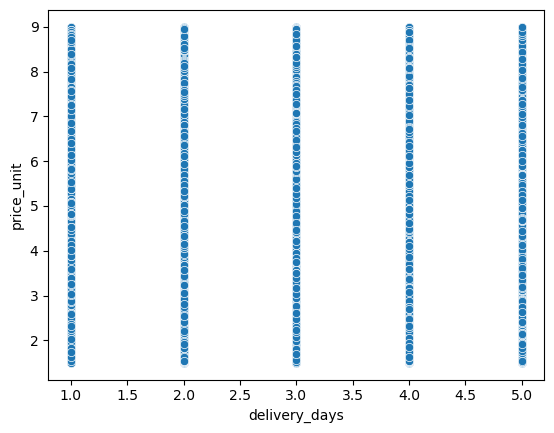

In [59]:
j += 1
bivariate_analysis(features_numerical[j], target)

See above for a more formal discussion about delivery days. Anyway we see that regardless of the day the price remains the same, fluctuating around whatever else it does. Hence, the correlation of essentially 0 (ie these two variables are independnet).

Comparing stock_available with our target feature of price_unit.
Their correlation is approximately -0.002.


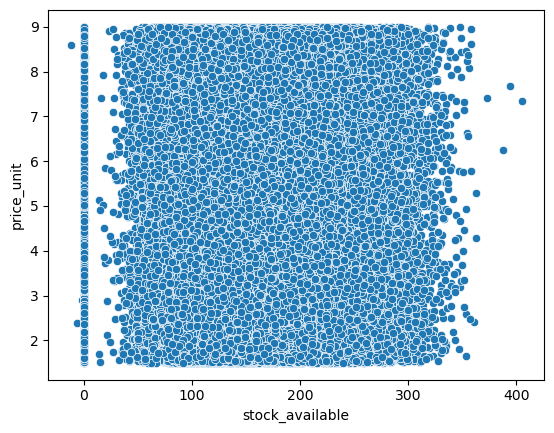

In [60]:
j += 1
bivariate_analysis(features_numerical[j], target)

Quite a cluster, but regardless we don't seem to notice any generic trend of the stock available and the item's price. Albeit a slight negative (which we'd assume if anything, as perhaps they jack up prices when almost out of stck), but essentially independnet like before.

Comparing delivered_qty with our target feature of price_unit.
Their correlation is approximately -0.004.


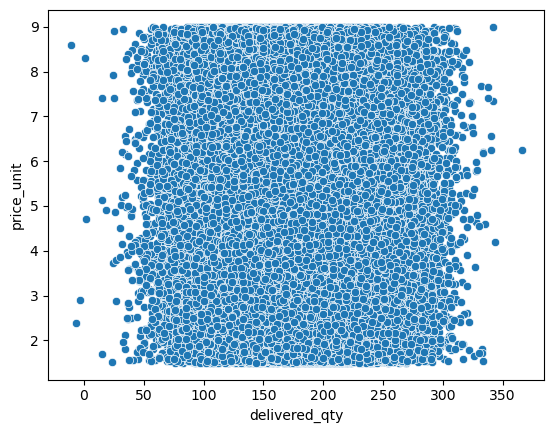

In [61]:
j += 1
bivariate_analysis(features_numerical[j], target)

See the previous entry.

Comparing units_sold with our target feature of price_unit.
Their correlation is approximately -0.001.


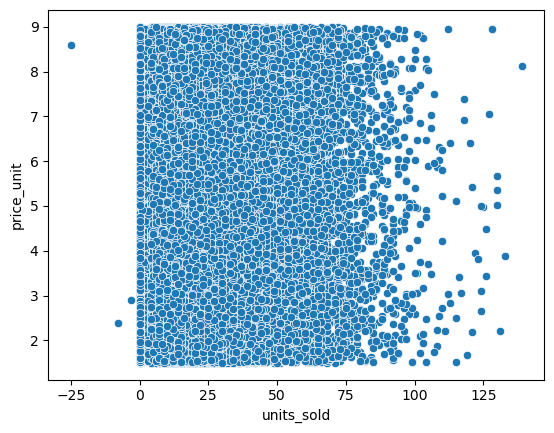

In [62]:
j += 1
bivariate_analysis(features_numerical[j], target)

See above.

Comparing year with our target feature of price_unit.
Their correlation is approximately 0.0.


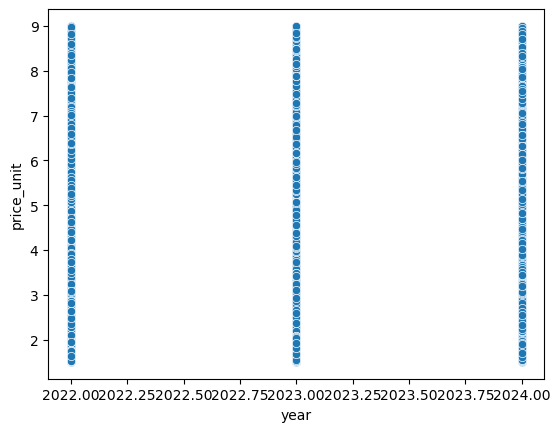

In [63]:
j += 1
bivariate_analysis(features_numerical[j], target)

Hmm, once again seemingly independent - which is interesting as this data was teaaed for prices. Perhaps I'll treat as a categorical and then we get:

In [64]:
print(f"Comparing year with our target feature of {target}.")
print(f"Recall that year has 3 categories.")
display(df.groupby('year')[target].describe())

Comparing year with our target feature of price_unit.
Recall that year has 3 categories.


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2022,29248.0,5.247033,2.170415,1.5,3.36,5.23,7.14,9.0
2023,77549.0,5.255697,2.163850,1.5,3.39,5.26,7.12,9.0
2024,83960.0,5.250267,2.168067,1.5,3.37,5.25,7.13,9.0


'22 is indeed a bit lower than the others, yet 23 is actually the highest. However, all their prices are still very similar.... Yet recall this is an average with many thousands so perhaps it is significant. We will see.<br> Note as well, again, in the counts - that '22 had relatively few sales compared to the others.

## Mutlivariate Analysis
 
 We'll start with heatmaps to look at everything in a bigger picture.

In [65]:
corr_features = features_numerical + [target]
print(corr_features)
not_corr_features = [col for col in df.columns if col not in corr_features]
print(not_corr_features)

['delivery_days', 'stock_available', 'delivered_qty', 'units_sold', 'year', 'price_unit']
['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region', 'pack_type', 'promotion_flag', 'weekday', 'monthday', 'month', 'quarter']


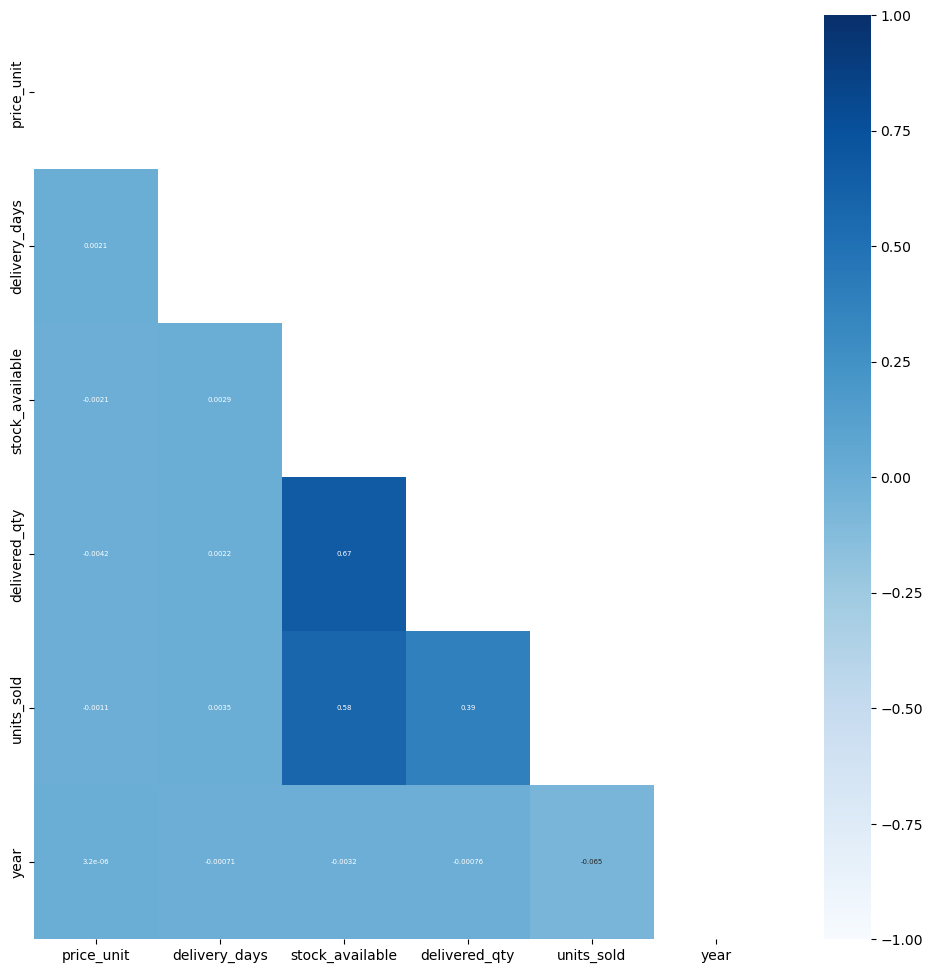

In [66]:
plt.figure(figsize=(12, 12))
corr = df.drop(columns=not_corr_features).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot=True, vmin = -1, vmax = 1, cmap='Blues', annot_kws={'fontsize':5});

The strongeest correlation observered is something we already noted - delivered quantity and stock available, which makes sense as I'm only going to have a stock of a physical item if there's a physical delivery. It also makes sense then that those two would be strongly tied together with units sold for the same reason (recall the categorical features of 'flag' and 'channel' that may be related.

When it comes to multivariate analysis, I think we'd have 240 combinations to look at (16 ncr 2 ie 16 * 15). Yeah, we're not lookng at all of those by default. I'll at least chose a few that interst me (and will serve as good coding practice). By default, I'd ask/get domain knowledge to want to look at any specific combination. I'll look at a few though on principal.

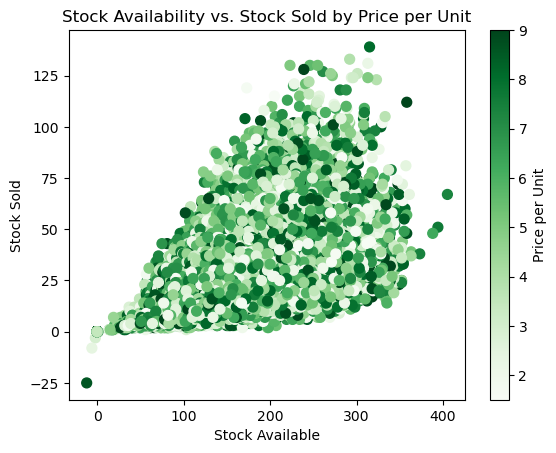

In [67]:
plt.scatter(df['stock_available'], df['units_sold'],
            c=df[target], s=50, cmap='Greens')
plt.colorbar(label='Price per Unit')
plt.title('Stock Availability vs. Stock Sold by Price per Unit')
plt.xlabel('Stock Available')
plt.ylabel('Stock Sold');

A bit of a hectic picture, as things usually tend to be once we get into multi-variate analysis. But, we do see first the general positive trend we noticed earlier in the heatmap between the two features (units sold and stock available). When it comes to our main point of interest, price, it seems independent. Which makes sense given the heatmap too.

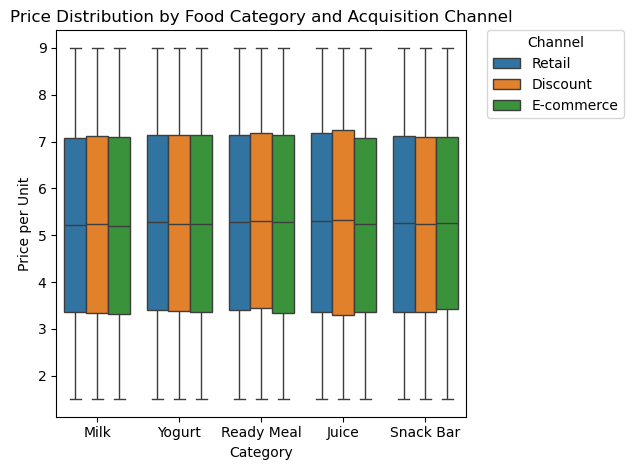

In [68]:
df['category'] = df['category'].replace({
    'ReadyMeal': 'Ready Meal',
    'SnackBar': 'Snack Bar'
})

sns.boxplot(x='category', y=target, hue='channel', data=df)

plt.title('Price Distribution by Food Category and Acquisition Channel')
plt.xlabel('Category')
plt.ylabel('Price per Unit')

plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Unfortunately this option didn't yield anything interesting as they all have similar spreads, whether it be whatever category against whatever channel.

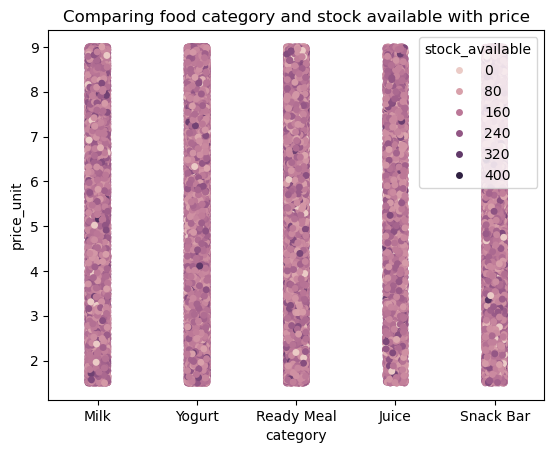

In [69]:
sns.stripplot(data=df, x='category', y=target, hue='stock_available', jitter=True)
plt.title('Comparing food category and stock available with price');

Another 'bust' in the sense that an obvious relationship is not sticking out to me. Worth a try though.

## Conclusion

That should conclude EDA and I suppose onto modeling. I might end it here with this demo though as I doubt I'll be modeling anything. (as once again we're really just exploring the data's features for this demo).
<br> It dawned on me that the data provider's purpose for this data was time series. Besides what we noticed with the quarters, it's interesting to note the potential effect of inflation. However, we definitely will not bother with that.